In [1]:
%autosave 0
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch

Autosave disabled


# Function approximators and Artificial Neural Networks

This lecture assumes basic knowledge on the [PyTorch](https://pytorch.org/) library 

For reference here is a short pytorch tutorial in spanish: 
- [Multilayer perceptron](https://github.com/magister-informatica-uach/INFO267/blob/master/unidad1/3_redes_neuronales.ipynb)
- [Convolutional Neural Networks](https://github.com/magister-informatica-uach/INFO267/blob/master/unidad1/4_red_convolucional.ipynb)

## Polynomial (linear) regression with Pytorch

Let's create synthetic data

We will fit this with a polynomial model

<IPython.core.display.Javascript object>


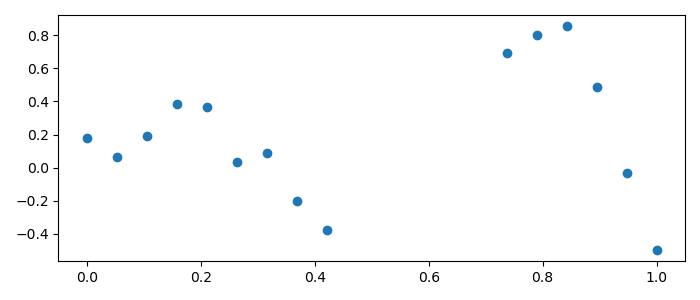

In [2]:
# Synthetic data
se = 0.1
np.random.seed(0)
x = np.linspace(0, 1, num=20) #100x1
x_test = np.linspace(-0.05, 1.05, num=200)
f = lambda x : x*np.sin(10*x)

x = np.delete(x, slice(9, 14))
y = f(x) + se*np.random.randn(len(x))
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.scatter(x, y);

x_torch = torch.from_numpy(x.astype('float32')).unsqueeze(1)
x_test = torch.from_numpy(x_test.astype('float32')).unsqueeze(1)
y_torch = torch.from_numpy(y.astype('float32')).unsqueeze(1)

The linear regressor model in PyTorch has one layer and no activation

We keep the degree of the pynomial as a free parameter

In [3]:
class LinearRegressor(torch.nn.Module):
    def __init__(self, degree=10):
        super(LinearRegressor, self).__init__()
        assert degree>0, "Degree has to be greater than zero"
        assert type(degree)==int, "Degree has to be an integer"
        self.degree = degree
        self.linear = torch.nn.Linear(degree, 1, bias=True)
        #torch.nn.init.normal_(self.linear.weight, 0.0, 1e-3)

    def forward(self, x):
        # polynomial expansion
        phi = torch.stack([x[:, 0]**(k+1) for k in range(self.degree)], dim=1)
        # linear layer
        return self.linear(phi)

We train this model using the Mean Square Error loss, 

```python
torch.nn.MSELoss(reduction='sum')
```

i.e. **we assumme a Gaussian likelihood**

We will optimize using batch gradient descent (GD) with adaptive learning rate (Adam)


```python
torch.optim.Adam(params,
                 lr=0.001,
                 betas=(0.9, 0.999),
                 eps=1e-08,
                 weight_decay=0,
                 amsgrad=False,
                )
```

The `weight_decay` argument multiplies the L2 norm of the parameters of the model 

Setting it to a non-zero value means that **we are considering a Gaussian prior**

**Activity:**

1. Change the number of basis and describe the results
1. Increase the noise and repeat the previous step
1. Modify the `weight_decay` parameter in Adam and repeat the previous steps 

Concepts to discuss: Complexity, generalization, overfitting, regularization

<IPython.core.display.Javascript object>


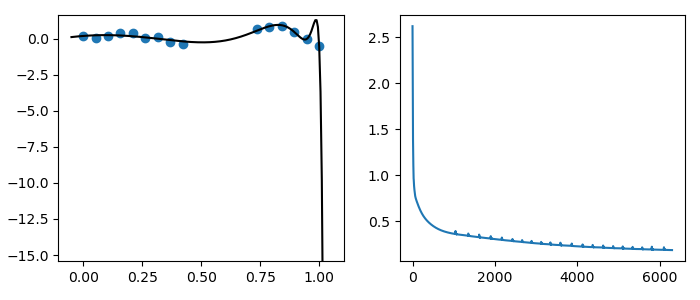

In [25]:
model = LinearRegressor(degree=100) # Change the degree
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, 
                             weight_decay=0.0) # Change the L2 penalty

fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)
f = model.forward(x_test).detach().numpy()
line1 = ax[0].plot(x_test.detach().numpy(), f, 'k-')
line2 = ax[1].plot([], [])
ax[0].scatter(x, y);

In [26]:
epoch_loss = np.zeros(shape=(10000,))
for k in tqdm(range(len(epoch_loss))):
    optimizer.zero_grad()
    f = model.forward(x_torch)
    loss = criterion(y_torch, f)
    loss.backward()
    #torch.nn.utils.clip_grad_value_(model.parameters(), 1e+1)
    optimizer.step()
    epoch_loss[k] = loss.item()
    #break    
    if k % 100 == 0:
        f = model.forward(x_test).detach().numpy()
        line1[0].set_ydata(f)
        line2[0].set_xdata(range(k))
        line2[0].set_ydata(epoch_loss[:k])
        ax[1].relim()
        ax[1].autoscale_view()
        fig.canvas.draw()

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Even though we use a polynomial base this is still linear regression because the model is linear with respect to the parameters

In this particular case we chose polynomials as basis to represent the data

How can we choose a basis in a more general case?

One answer:

> Don't choose, let the model find the basis

## Artificial Neural networks

[Artificial neural networks](https://docs.google.com/presentation/d/1IJ2n8X4w8pvzNLmpJB-ms6-GDHWthfsJTFuyUqHfXg8/edit?usp=sharing) (ANN) are non-linear parametric function approximators built by connecting **simple units**

These units are simplified models of biological neurons. The artificial neuron is a linear regressor followed by a non-linear activation function

$$
y =  g \left( b + \sum_{d=1}^D w_{d} x_d  \right)
$$

where for example

$$
g(x) = \frac{1}{1 + e^{-x}}
$$

Feed-forward ANN are organized in layers. Each layer has a certain amount of neurons (user-defined)

**Multilayer perceptron (MLP) architecture:** Every unit is connected to all units of its previous and next layers. For example a network with four inputs, two outputs and one **hidden layer** with eight neurons:



Mathematically, the output of the hidden layer is

$$
h_j =  g_1 \left( b_j + \sum_{d=1}^{N_x} w_{jd} x_d  \right), j=1, 2, \ldots, N_h
$$

and the output layer

$$
\begin{align}
f_i &=   g_2 \left(b_i + \sum_{j=1}^{N_h} w_{ij} h_j \right) \nonumber \\
&= g_2 \left(b_i + \sum_{j=1}^{N_h} w_{ij} g_1 \left( b_j + \sum_{d=1}^{N_x} w_{jd} x_d  \right) \right), i = 1, \ldots, N_o \nonumber
\end{align}
$$

where $g_1$, $g_2$ may be different (user choice)

The parameters of the network are the weight and biases of the linear regressors

### Predictive prior distribution of MLP (Gaussian prior)

The parameter vector $\theta$ includes the weights and biases of all the neurons

Let's consider a Gaussian prior for $\theta$ and study the space of possible models

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
x_nn = np.linspace(-5, 5, num=1000)[:, None].astype('float32') #100x1

class MLP(torch.nn.Module):
    def __init__(self, Nh=10, sw=5, sb=5):
        super(MLP, self).__init__()
        self.hidden1 = torch.nn.Linear(1, Nh)
        #self.hidden2 = torch.nn.Linear(Nh, Nh)
        #self.hidden3 = torch.nn.Linear(Nh, Nh)

        self.output = torch.nn.Linear(Nh, 1)
        #for layer in [self.hidden1, self.hidden2, self.hidden3, self.output]:
        for layer in [self.hidden1, self.output]:
            torch.nn.init.normal_(layer.weight, 0.0, sw)
            torch.nn.init.normal_(layer.bias, 0.0, sb)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        z = self.activation(self.hidden1(x))
        #z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        return self.output(z)
    
for i in range(10):
    model = MLP(Nh=1000)
    y_nn = model.forward(torch.from_numpy(x_nn)).detach().numpy()
    ax.plot(x_nn, y_nn, c='tab:blue', alpha=0.5)

**Activity**

- How does it compare to the single linear regressor? 
- What happens when you add more neurons? 
- What happens if you remove the nonlinearity? 
- What happens if you change the nonlinearity?
- What happens when you add more layers?

### Probabilistic interpretation of ANN

Let's consider a simple MLP architecture for regression

- one hidden layer with $H$ neurons
- input dimensionality $D$ and output dimensionality $K$
- $g(\cdot)$ a nonlinear activation function (sigmoid, tanh, ReLU, etc)

$$
\begin{align}
f_i &=   b_i + \sum_{j=1}^H w_{ij} h_j  \nonumber \\
&=  b_i + \sum_{j=1}^H w_{ij} g \left( b_j + \sum_{d=1}^D w_{jd} x_d  \right) \nonumber
\end{align}
$$

The vector parameter $\vec \theta$ contains the weight and biases of both layers

We fit the parameters by minimizing the **Mean Square Error** cost function 

$$
\min_\theta \sum_n  \sum_i \left(y_{i}^{(n)} - f_i(x^{(n)}) \right)^2
$$

> This is equivalent to the **MLE solution with Gaussian likelihood** (known spherical covariance)

Typically an L2 regularizer is included to penalize complexity and improve generalization

$$
\min_\theta \sum_n  \sum_i  \left(y_{i}^{(n)} - f_i(x^{(n)}) \right)^2 + \lambda \sum_k \theta_k^2
$$

> This is equivalent to the **MAP solution with Gaussian likelihood and Gaussian prior** (zero-mean)

In both cases there is no closed-form solution because of the non-linear activations

The cost function is typically minimized with iterative methods such as **gradient descent**

**Long story short:**

> Conventional neural network training obtains MLE/MAP point estimates

For classification we arrive to the same conclusion except that 

- sigmoid or softmax activation is used in the output layer
- cross-entropy cost function is used instead of MSE: **Bernoulli/Categorical likelihood**

## Non-linear regressor using MLP

Let's go back to the polynomial regression problem

<IPython.core.display.Javascript object>


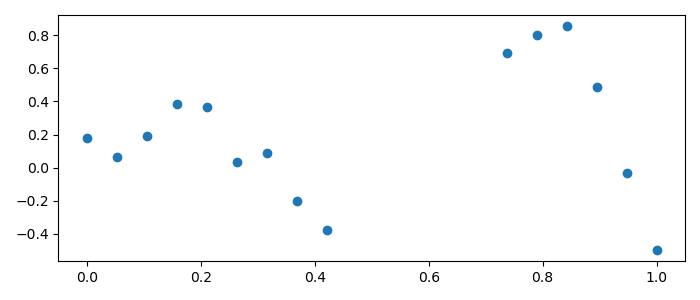

In [27]:
# Synthetic data
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.scatter(x, y);

This time we will use a Multi-Layer Perceptron (MLP) instead of a polynomial regressor

We set a non-linear hyperbolic tangent activation function as hidden activation (you can change this later)

In [28]:
class MLP(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super(MLP, self).__init__()
        self.hidden1 = torch.nn.Linear(1, n_hidden, bias=True)
        #self.hidden2 = torch.nn.Linear(n_hidden, n_hidden, bias=True)
        self.output = torch.nn.Linear(n_hidden, 1, bias=True)
        self.activation = torch.nn.Tanh()
        
    def forward(self, x):
        z = self.activation(self.hidden1(x))
        #return self.output(self.activation(self.hidden2(z)))
        return self.output(z)

How many hyperbolic tangent basis do we need to fit this data?

**Activity**

- Explore the solutions using 1, 2, 5 and 10 units in the hidden layer
- Explore the solutions using an additional hidden layer

<IPython.core.display.Javascript object>


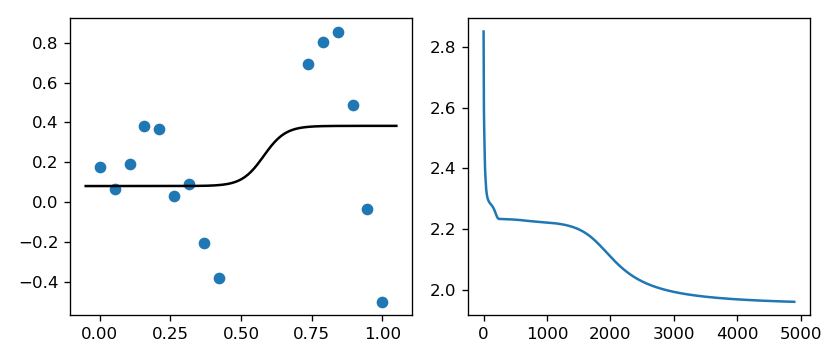

In [29]:
model = MLP(n_hidden=1) # Change the number of hidden neurons

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, 
                             weight_decay=0.0) # L2 regularization

fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True, dpi=120)
f = model.forward(x_test).detach().numpy()
line1 = ax[0].plot(x_test.detach().numpy(), f, 'k-')
line2 = ax[1].plot([], [])
ax[0].scatter(x, y);

In [30]:
epoch_loss = np.zeros(shape=(5000,))
for k in tqdm(range(len(epoch_loss))):
    optimizer.zero_grad()
    f = model.forward(x_torch)
    loss = criterion(y_torch, f)
    loss.backward()
    optimizer.step()
    epoch_loss[k] = loss.item()
    #break    
    if k % 100 == 0:
        f = model.forward(x_test).detach().numpy()
        line1[0].set_ydata(f)
        line2[0].set_xdata(range(k))
        line2[0].set_ydata(epoch_loss[:k])
        ax[1].relim()
        ax[1].autoscale_view()
        fig.canvas.draw()

  0%|          | 0/5000 [00:00<?, ?it/s]

## Deep Learning

More complex and flexible models are obtained by increasing the number of hidden layers (depth) and the number of neurons (width) 



But 

> The more parameters, the more difficult to train: Overfitting, vanishing gradients, ...

With 
- Data availability on the rise 
- Faster hardware: GPUs (CUDA, tensor-cores)
- Regularization: penalty on parameters, data augmentation, dropout, ...
- Clever architectures and activations: Convolutional Neural Networks, Long-short term memories, ReLU, ...


We are able to train **very deep neural network models** that have become the current state of the art in [pattern recognition problems](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)

**Why are deep models needed?**

The MLP with one hidden layer (shallow network) is a [universal approximator](http://cognitivemedium.com/magic_paper/assets/Hornik.pdf)

> (In theory) we could obtain a shallow network that is *as flexible* as a deep network


> (But) it may require an extremely large number of hidden-layer neurons (infinite)

In practice you need **flexible** but also **compact** models

**Paper reading**

- https://arxiv.org/pdf/1706.04599.pdf